## LSTM - MTA-KDD-19

#### Import libraries

In [ ]:
%%capture
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score
from tensorflow.keras import layers
import seaborn as sns

### Import data and split into train/validation/test sets
For this report, we access the MTA-KDD-19 dataset (https://github.com/IvanLetteri/MTA-KDD-19)

In [ ]:
dfLEG = pd.read_csv('https://raw.githubusercontent.com/IvanLetteri/MTA-KDD-19/master/datasetLegitimate33featues.csv')
dfMTA = pd.read_csv('https://raw.githubusercontent.com/IvanLetteri/MTA-KDD-19/master/datasetMalware33featues.csv')
df = pd.concat([dfMTA, dfLEG])
df.shape

(64554, 34)

In [ ]:
df.head()

,FinFlagDist,SynFlagDist,RstFlagDist,PshFlagDist,AckFlagDist,DNSoverIP,TCPoverIP,UDPoverIP,MaxLen,MinLen,...,NumPorts,FlowLEN,FlowLENrx,repeated_pkts_ratio,NumCon,NumIPdst,Start_flow,DeltaTimeFlow,HTTPpkts,label
0,0.478168,1.144246,-0.716937,0.671470,1.089129,-0.154516,0.154711,-0.156991,-0.009901,-1.028609,...,-0.889691,0.479515,0.284428,0.862578,5.253913,5.142702,0.562400,-0.052248,1.487787,1.0
1,-1.204652,0.316746,-0.716937,1.537622,1.135609,-0.154516,0.154711,-0.156991,0.722669,0.628640,...,0.293799,1.301840,-0.036629,-0.908981,-0.190341,-0.194497,0.562400,-0.315281,1.786307,1.0
2,-1.204652,-0.216194,-0.716937,-0.457715,-0.848148,-0.154516,0.154711,-0.156991,-0.172436,0.628640,...,-0.889691,-0.452523,-0.049479,-0.671509,-0.190341,-0.194497,0.562400,-1.197897,0.583908,1.0
3,0.478168,0.636365,-0.716937,1.615480,1.274407,-0.154516,0.154711,-0.156991,0.722669,0.628640,...,0.823293,1.416370,-0.042111,-1.626711,-0.190341,-0.194497,0.562400,-0.097754,1.805515,1.0
4,1.747840,1.867679,1.867097,0.903129,1.473227,6.778562,-7.182148,6.836627,0.485384,0.628640,...,1.116241,0.868445,0.678529,0.902818,5.253913,5.142781,0.563213,0.885878,1.614688,1.0


In [ ]:
# empty list and DataFrame to capture statistics
results = [] 
precision_recall_all = pd.DataFrame()

# split into input (X) and output (y) variables
X = df.iloc[:,:33]
y = df.iloc[:,33]

# split into training (80%), validation (10%), and test (10%) sets
rand_seed = 123
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8,
                                                  random_state = rand_seed,
                                                  stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, 
                                                    train_size = 0.5,
                                                    random_state = rand_seed,
                                                    stratify = y_rem)
    
# build LSTM model

# Input for variable-length sequences of integers
inputs = keras.Input(shape = (None, ), dtype = "int32")
# Embed each integer in a 28,128-dimensional vector
x = layers.Embedding(X.shape[1], 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

# compile and train model
model.compile("adam", "binary_crossentropy", metrics = ["accuracy"])
model.fit(X_train, y_train, batch_size = 32, epochs = 2, 
          validation_data = (X_valid, y_valid))
    
# make predictions with model (.50 threshold)
predictions = (model.predict(X_test) > 0.5).astype(int)

# calculate metrics for each model
precision, recall, fscore, support = score(y_test, predictions, 
                                           average = 'binary')
auc = roc_auc_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
    
# append metrics to results
results.append(
    {
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': fscore,
      'AUC': auc
    })
    
# write data for precision recall curves to csv
cols = ['precision', 'recall', 'thresholds']
precision_recall = precision_recall_curve(y_test, model.predict(X_test))
precision_recall = pd.DataFrame(precision_recall, index = cols).transpose()
precision_recall_all = precision_recall_all.append(precision_recall)

print(results)

Epoch 1/2
1614/1614 [==============================] - 33s 13ms/step - loss: 0.2155 - accuracy: 0.9078 - val_loss: 0.1106 - val_accuracy: 0.9563
Epoch 2/2
202/202 [==============================] - 1s 4ms/step
[{'Accuracy': 0.9753717472118959, 'Precision': 0.9671990872789503, 'Recall': 0.9871906841339155, 'F1 Score': 0.9770926379484224, 'AUC': 0.9745619094287585}]


<ipython-input-35-4ca63c647f89>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precision_recall_all = precision_recall_all.append(precision_recall)


In [ ]:
# view results
results_df = pd.DataFrame(results)
results_df

,Accuracy,Precision,Recall,F1 Score,AUC
0,0.975372,0.967199,0.987191,0.977093,0.974562


In [ ]:
# print results and precision_recall to csv
results_df.to_csv('results.csv') 
precision_recall_all.to_csv('precision_recall.csv')

In [ ]:
precision_recall_all.head()

,precision,recall,thresholds
0,0.532063,1.0,0.000001
1,0.532146,1.0,0.000001
2,0.532228,1.0,0.000002
3,0.532311,1.0,0.000002
4,0.532393,1.0,0.000002


<Axes: xlabel='recall', ylabel='precision'>

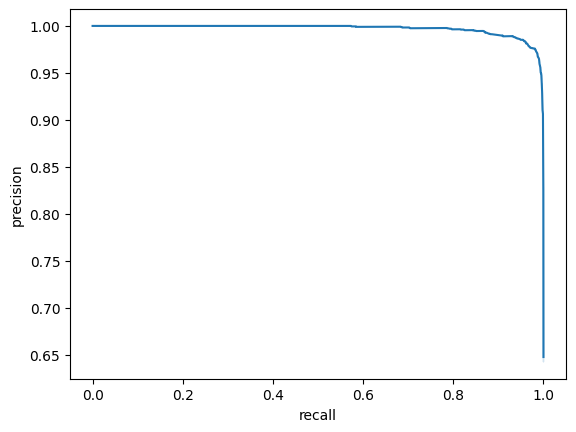

In [ ]:
# precision recall graph
sns.lineplot(data = precision_recall_all, x = 'recall', y = 'precision')